In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import csv
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
raw_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
raw_test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
raw_test2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
raw_df = raw_df.append(raw_test_df)
raw_df.head(20)
raw_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

## Data Explore

In [3]:
raw_df.describe()

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.400000e+04,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,1.399900e+04,1.400000e+04,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,12498.000000
mean,1.542772e+06,1.661643,1.238929,848.388643,10681.801286,40.727746,-73.956776,2.368400e+06,2.285087e+09,10.233350,...,0.268500,0.170714,0.262643,0.208214,0.072357,0.133786,0.089571,3591.997214,0.495786,6.198232
std,4.323673e+06,1.084151,0.550979,513.039489,592.728072,0.053635,0.042994,1.242507e+06,1.200828e+09,12.003629,...,0.443195,0.376273,0.440086,0.406045,0.259088,0.340434,0.285577,2874.099247,0.500000,7.728606
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.168405,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.231400e+04,1.000000,1.000000,604.000000,10023.000000,40.693256,-73.986095,1.052178e+06,1.011286e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.545810e+05,2.000000,1.000000,800.000000,11103.000000,40.729048,-73.961554,3.018885e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.267980e+05,2.000000,1.000000,1000.000000,11218.000000,40.764801,-73.936080,3.325600e+06,3.050558e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877211e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.029930e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


In [4]:
raw_df.shape

(14000, 38)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 7236931 to 7463404
Data columns (total 38 columns):
addr_unit                 13890 non-null object
building_id               14000 non-null int64
bedrooms                  14000 non-null int64
bathrooms                 14000 non-null float64
size_sqft                 14000 non-null float64
created_at                14000 non-null object
addr_street               14000 non-null object
addr_city                 14000 non-null object
addr_zip                  14000 non-null int64
addr_lat                  14000 non-null float64
addr_lon                  14000 non-null float64
bin                       13999 non-null float64
bbl                       14000 non-null int64
floor_count               14000 non-null float64
year_built                13530 non-null float64
min_to_subway             13857 non-null float64
has_doorman               14000 non-null int64
has_elevator              14000 non-null int64
has_fireplace    

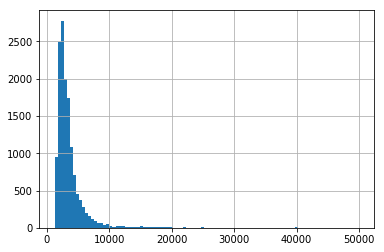

In [6]:
raw_df['rent'].hist(bins=100)

### Seperate all features into continuous, categorical and binary features.

For those none relatived features as below, we have excluded them from the features grouping: 
- addr_unit: no relationship
- building_id: no relationship
- addr_lat: hard to analyze latitude
- addr_lon: hard to analyze longtitude
- bin: no relationship
- bbl: no relationshio
- description: hard to build a NLP model
- unit: no relationship


In [7]:
continuous_features =['bathrooms','bedrooms','size_sqft','floor_count','year_built','min_to_subway','floornumber' ]
caterigal_features =['addr_street','addr_city','addr_zip','neighborhood','borough','line' ]
binary_features = ['has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets', 
                   'has_washer_dryer','has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
                   'has_childrens_playroom', 'no_fee', ]

## Import external dataset from Internal Revenue Service
 - We will import the 2017 individual income Tax statistic dataset from IRS website(https://www.irs.gov/pub/irs-soi/17zpallagi.csv).
 - We will expend a new feature: **average_income** based on zipcode to our raw dataset 

In [8]:
raw_income_data=pd.read_csv('https://www.irs.gov/pub/irs-soi/17zpallagi.csv', index_col=0)
raw_income_data.columns

Index(['STATE', 'zipcode', 'agi_stub', 'N1', 'mars1', 'MARS2', 'MARS4', 'ELF',
       'CPREP', 'PREP',
       ...
       'N85300', 'A85300', 'N11901', 'A11901', 'N11900', 'A11900', 'N11902',
       'A11902', 'N12000', 'A12000'],
      dtype='object', length=152)

In [9]:
raw_income_data.describe()

,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,PREP,DIR_DEP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
count,166537.000000,166537.000000,1.665370e+05,1.665370e+05,1.665370e+05,166537.000000,1.665370e+05,166537.000000,1.665370e+05,1.665370e+05,...,166537.000000,1.665370e+05,166537.000000,1.665370e+05,1.665370e+05,1.665370e+05,1.665370e+05,1.665370e+05,166537.000000,1.665370e+05
mean,48870.221668,3.499883,1.797506e+03,8.568076e+02,6.466075e+02,257.395354,1.595375e+03,109.165711,9.565737e+02,1.115313e+03,...,52.247849,2.652260e+02,366.565508,2.075837e+03,1.385102e+03,4.864975e+03,1.349381e+03,3.932834e+03,43.103875,8.790301e+02
std,27140.457939,1.707903,3.682065e+04,2.157115e+04,1.180901e+04,6579.521856,3.234179e+04,2546.536828,1.996698e+04,2.347348e+04,...,2663.659358,1.535593e+04,6891.242958,6.608186e+04,2.947749e+04,1.012458e+05,2.909491e+04,7.693938e+04,947.324343,4.399491e+04
min,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,27030.000000,2.000000,7.000000e+01,0.000000e+00,4.000000e+01,0.000000,6.000000e+01,0.000000,4.000000e+01,4.000000e+01,...,0.000000,0.000000e+00,20.000000,2.100000e+01,5.000000e+01,1.580000e+02,4.000000e+01,1.410000e+02,0.000000,0.000000e+00
50%,48876.000000,3.000000,2.500000e+02,7.000000e+01,1.100000e+02,20.000000,2.200000e+02,0.000000,1.500000e+02,1.400000e+02,...,0.000000,0.000000e+00,60.000000,1.550000e+02,1.800000e+02,6.220000e+02,1.700000e+02,5.480000e+02,0.000000,0.000000e+00
75%,70601.000000,5.000000,1.020000e+03,3.400000e+02,3.800000e+02,90.000000,9.100000e+02,60.000000,5.600000e+02,5.900000e+02,...,0.000000,0.000000e+00,220.000000,6.870000e+02,7.400000e+02,2.484000e+03,7.100000e+02,2.207000e+03,30.000000,6.400000e+01
max,99999.000000,6.000000,5.824360e+06,4.130490e+06,1.757700e+06,982390.000000,4.980210e+06,475240.000000,3.387570e+06,3.233490e+06,...,763140.000000,4.031847e+06,890950.000000,1.750126e+07,4.598480e+06,1.667374e+07,4.561540e+06,9.443931e+06,186110.000000,1.056186e+07


### Income Dataset Description 
This dataset comes from the IRS website's 2017 ZIP Code Data (SOI) about Individual Income Tax Statistics.
According to the documentation's overview,the Statistics of Income (SOI) Division’s ZIP code data is tabulated using individual income tax returns (Forms 1040) filed with the Internal Revenue Service (IRS) during the 12-month period, January 1, 2018 to December 31, 2018.
The original dataset contains many income and Tax Items, we only keep the ones that are relevant: 
- STATEFIPS:The State Federal Information Processing System (FIPS) code
- STATE: The State associated with the ZIP code
- ZIPCODE: 5-digit Zip code
- agi_stub: Size of adjusted gross income
- N1: Total number of returns
- A02650: Number of returns with total income

Our goal is to find the average income of each zipcode.

### Clean the raw income data and rename feature

In [10]:
raw_income_data = raw_income_data.loc[raw_income_data['STATE']=='NY']
raw_income_data.rename(columns = {'N1':'total_returns', 'A02650':'total_income'}, inplace = True) 
raw_income_data = raw_income_data[['STATE','zipcode','agi_stub','total_returns', 'total_income']]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']<99999]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']>0]


### Function to calculate the average income by zip code
Each zip code has 6 different sizes of adjusted gross income which means we have 6 different number of total returns and total income for one zip code.
By using the np.where and sum function, we can obtain the sum of income and sum of returns for each zip code. The income of the original dataset was in thousands of dollar so we need to multiply the sum of income by 1000 and then find the average. Since some zip code was not in the original set, we ingore those average that is NaN and only write the meaningful averages to csv file for future use.

- Calculate average income 
- Export to ny_income_2017.csv for storage
- For next time, no need to import the raw_income_dataset again

In [11]:
average_income = pd.DataFrame({'addr_zip':[],'zip_average_income':[]})

def calculate_avg_income():
    global average_income
    for zipcode in range(10001, 14906):
        current_sum=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_income'],0).sum()
        current_returns=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_returns'],0).sum() 
        if(current_returns <=0 or current_sum<=0):
            continue
        avg_income=(current_sum*1000)/current_returns
        new_row={'addr_zip':zipcode,'zip_average_income':avg_income}
        average_income=average_income.append(new_row,ignore_index=True)           
calculate_avg_income()
average_income.head(5)

,addr_zip,zip_average_income
0,10001.0,183859.908735
1,10002.0,59669.401750
2,10003.0,306277.962003
3,10004.0,385265.306122
4,10005.0,391201.520270


 - We realize that the income dataset is missing all income data between zipcode 11239 - 11354, we will take an averge of zipcode income for 11239 and 11354 to replace any zipcode income in between 
 - In our training and testing dataset, only the zipcode income 11249 is missing

In [12]:
print(list(set(raw_df['addr_zip']) - set(average_income['addr_zip'])))
print(list(set(raw_test_df['addr_zip']) - set(average_income['addr_zip'])))

[11249]
[11249]


**Insert a new row for zipcode income 11249 into the average_income dataframe**

In [13]:
avg_income = (average_income.loc[(average_income['addr_zip']==11239)].iloc[0]['zip_average_income'] +
             average_income.loc[(average_income['addr_zip']==11354)].iloc[0]['zip_average_income'])/2
new_row = {'addr_zip':11249,'zip_average_income':avg_income}
average_income=average_income.append(new_row,ignore_index=True)  

### Merge the raw train  dataset with the income dataset by addr_zip

In [14]:
raw_test2_df=raw_test_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')
raw_df=raw_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')

### Find zip_average_income and rent cooleration

In [15]:
continuous_features.append('zip_average_income')

In [16]:
continuous_df = raw_df[['zip_average_income','rent']]
continuous_df.corr()['rent'][:-1]


zip_average_income    0.393228
Name: rent, dtype: float64

**The correlation between zip_average_income and rent is 0.403558, it is good enough to consider as a important feature that might impact the rent**

# Data Cleaning


### Handling missing data
In order to handle missing data in this dataset, we frist find and count all the null values.

In [17]:
raw_df.isna().sum()

addr_unit                  110
building_id                  0
bedrooms                     0
bathrooms                    0
size_sqft                    0
created_at                   0
addr_street                  0
addr_city                    0
addr_zip                     0
addr_lat                     0
addr_lon                     0
bin                          1
bbl                          0
floor_count                  0
year_built                 470
min_to_subway              143
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
has_garden                   0
has_childrens_playroom       0
rent                         0
no_fee                       0
descript

As we can see from the result,there are missing data appearing on: 
- addr_unit
- bin 
- year_built 
- min_to_subway 
- description 
- neighborhood 
- unit 
- floornumber 
- line 

Base on our data exploration, we can see that in this case, all features beside year_built,min_to_subway,neighborhood,and floornumber has not much impact to our final result, thus we don't need to worry about them.

Then, we will be dropping the rows which we don't have values for year_built, min_to_subway, neighborhood, and floornumber.

In [18]:
# We will call the new df md_df
# md_df = raw_df.loc[
#     raw_df.year_built.notnull() &
#     raw_df.min_to_subway.notnull() & 
#     raw_df.neighborhood.notnull() & 
#     raw_df.floornumber.notnull()
# ]

# Reminder:
# use mode to replace NAN value, compare both method when creating models
md_df = raw_df.loc[
    raw_df.year_built.notnull() &
    raw_df.min_to_subway.notnull() & 
    raw_df.neighborhood.notnull() 
]

md_df['floornumber'].fillna(md_df['floornumber'].mode()[0], inplace=True)
raw_test2_df['floornumber'].fillna(raw_test2_df['floornumber'].mode()[0], inplace=True)



print("original shape of dataset:",raw_df.shape)
print("shape of dataset after handling missing data:",md_df.shape)

original shape of dataset: (14000, 39)
shape of dataset after handling missing data: (13394, 39)


D:\Anaconda\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Remove outliers

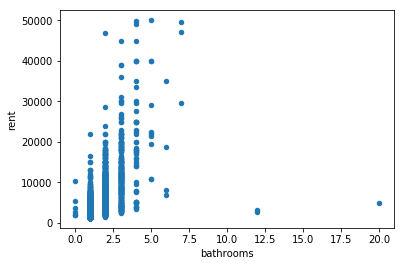

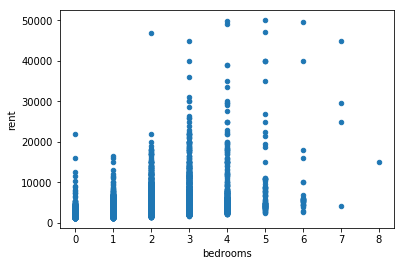

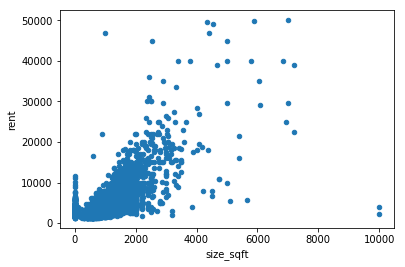

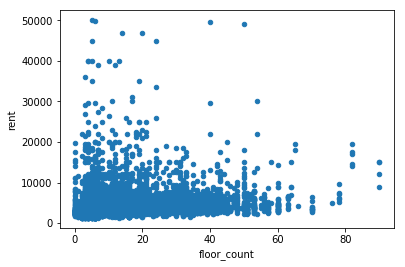

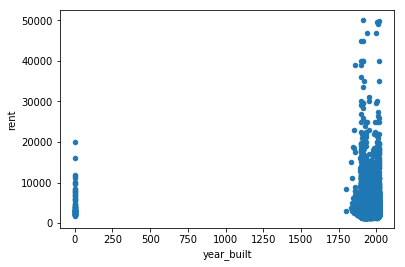

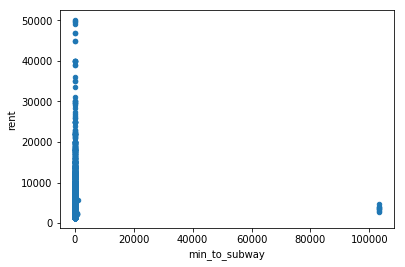

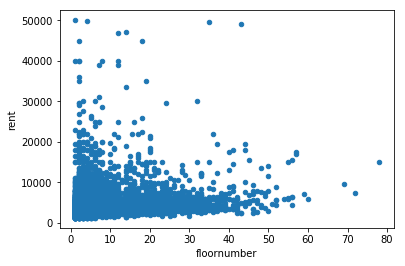

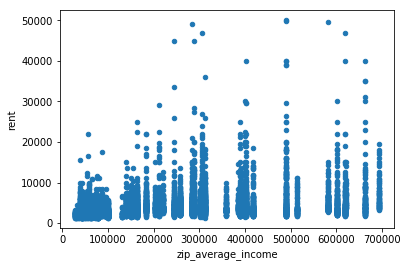

In [19]:
for feature in continuous_features:
    md_df.plot.scatter(feature, 'rent')

In [20]:
md_df.loc[md_df['size_sqft']==0].shape

(983, 39)

**drop size_sqrt = 0 for now, since there are 713 rows, might replace with mode when creating models**

In [21]:
def remove_outliers(md_df, feature, low_value, high_value):
    print(feature, ': ', md_df.shape)
    md_df = md_df[md_df[feature]>low_value]
    md_df = md_df[md_df[feature]<=high_value]
    md_df.reset_index(drop=True,inplace=True)
    print(feature, ': ', md_df.shape)
    return md_df

md_df = remove_outliers(md_df, 'bathrooms', 0, 12)
md_df = remove_outliers(md_df, 'size_sqft', 0, 10000)
md_df = remove_outliers(md_df, 'year_built', 1700, 2019)
md_df = remove_outliers(md_df, 'min_to_subway', 0, 60)
md_df = remove_outliers(md_df, 'floornumber', 0, 60)

md_df['year_built'] = 2019 - md_df['year_built'].astype(int)

bathrooms :  (13394, 39)
bathrooms :  (13387, 39)
size_sqft :  (13387, 39)
size_sqft :  (12407, 39)
year_built :  (12407, 39)
year_built :  (12336, 39)
min_to_subway :  (12336, 39)
min_to_subway :  (12324, 39)
floornumber :  (12324, 39)
floornumber :  (12321, 39)


### Encode categorical feature and drop useless features

In [22]:
boroughs = np.array(md_df['borough'].unique())

for borough in boroughs:
    md_df[borough] = md_df['borough'].apply(lambda x : int(x == borough))
    raw_test2_df[borough] = raw_test2_df['borough'].apply(lambda x : int(x == borough))

features_notNeed = ['addr_unit', 'building_id', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'bin', 'bbl', 'description', \
                    'neighborhood', 'unit', 'borough', 'line']

md_df = md_df.drop(features_notNeed, axis=1)

### Use pair coorelation for continuous features

In [23]:
continuous_df = md_df[continuous_features+['rent']]
continuous_df.corr()['rent'][:-1]

bathrooms             0.640607
bedrooms              0.346474
size_sqft             0.703703
floor_count           0.251880
year_built           -0.104735
min_to_subway        -0.066488
floornumber           0.246590
zip_average_income    0.404019
Name: rent, dtype: float64

### Check coorelation for binary features

In [24]:
md_df[binary_features+['rent']].corr()['rent'][:-1]
coor_results= []

for feature in binary_features:
  df = raw_df.groupby([feature]).aggregate(['mean'])['rent']
  df[feature]= df.index
  coor_results.append(df.corr().iloc[0][1])
coor_df = pd.DataFrame({'Coorelation': coor_results,'Feature':binary_features})
coor_df


,Coorelation,Feature
0,1.0,has_doorman
1,1.0,has_elevator
2,1.0,has_fireplace
3,1.0,has_dishwasher
4,1.0,is_furnished
5,1.0,has_gym
6,1.0,allows_pets
7,1.0,has_washer_dryer
8,1.0,has_garage
9,1.0,has_roofdeck


As we can see in the correlation table, all binrary features highly affected the rents. When we build the models, we should include all binary features.

## Build Models

In [26]:
md_df = shuffle(md_df).reset_index(drop=True)


In [27]:
features = list(md_df.columns)
features.remove('rent')
k_fold = KFold(n_splits=5)

In [28]:
def get_cv_results(regressor):
    
    results = []
    for train, test in k_fold.split(md_df):
        regressor.fit(md_df.loc[train, features], md_df.loc[train, 'rent'])
        y_predicted = regressor.predict(md_df.loc[test, features])
        accuracy = mean_squared_error(md_df.loc[test, 'rent'], y_predicted)**0.5
        results.append(accuracy)

    return np.mean(results), np.std(results)

In [29]:
rforest = RandomForestRegressor(
    #random_state=random_state, 
    max_depth=5,
    n_estimators=100
)

rforest.fit(md_df[features], md_df['rent'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [30]:
for feature,score in zip(features,rforest.feature_importances_):
    print(feature, ' ', score)

bedrooms   0.005127542249295216
bathrooms   0.1522969459897195
size_sqft   0.5958813689667514
addr_lat   0.008560295719377432
addr_lon   0.010372795408822952
floor_count   0.006354893444416644
year_built   0.005859362853318376
min_to_subway   0.0019119634885813822
has_doorman   0.0006547689711758723
has_elevator   0.0010777894931826475
has_fireplace   0.000646457005806676
has_dishwasher   0.001169284537120877
is_furnished   0.0013877057963261083
has_gym   0.003571631567734944
allows_pets   0.00017168867023792527
has_washer_dryer   0.0005999260020202793
has_garage   6.5859305771419485e-06
has_roofdeck   0.003470875788389105
has_concierge   0.0003464171145190898
has_pool   0.0004050263431577515
has_garden   0.0007812571247259686
has_childrens_playroom   2.9752405041680716e-05
no_fee   0.0012093768377925177
floornumber   0.004495712427909388
zip_average_income   0.19277196119069476
Brooklyn   0.00018123486391629831
Manhattan   0.0006561932774855607
Queens   0.0
Bronx   1.1865319024302213e